In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

2025-05-02 11:14:55.975136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746184496.183166      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746184496.243017      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Hyperparameters configurations
configs = [
    {
        'name': 'model1',
        'BATCH_SIZE': 32,
        'NUM_CLASSES': 6,
        'EPOCHS': 10,
        'LEARNING_RATE': 1e-3,
        'IMAGE_SIZE': (150, 150),
        'recon_weight': 0.5
    },
    {
        'name': 'model2',
        'BATCH_SIZE': 64,
        'NUM_CLASSES': 6,
        'EPOCHS': 10,
        'LEARNING_RATE': 5e-4,
        'IMAGE_SIZE': (150, 150),
        'recon_weight': 0.3
    }
]

In [3]:
# Data directories
DATA_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train"
VAL_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test"

# Image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

# Dataset and DataLoaders
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Autoencoder + Classifier Model
class ConvAutoencoderClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvAutoencoderClassifier, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 150 -> 75
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 75 -> 38
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 38 -> 19
            nn.ReLU(),
        )

        # Classifier head
        self.flatten = nn.Flatten()
        self.fc_cls = nn.Sequential(
            nn.Linear(128 * 19 * 19, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # 19 -> 38
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # 38 -> 76
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),   # 76 -> 152
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, stride=1, padding=1),  # 152 x 152
            nn.Upsample(size=(150, 150), mode='bilinear', align_corners=False)  # back to 150 x 150
        )

    def forward(self, x):
        encoded = self.encoder(x)
        logits = self.fc_cls(self.flatten(encoded))
        recon = self.decoder(encoded)
        return logits, recon

In [5]:
def train_and_evaluate(config):
    print(f"\nTraining {config['name']} with config: {config}")
    
    # Create unique directory for TensorBoard logs
    log_dir = f"runs/{config['name']}"
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir)
    
    # Create model directory
    model_dir = f"models/{config['name']}"
    os.makedirs(model_dir, exist_ok=True)
    
    # DataLoaders with current config
    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False)

    # Instantiate model, loss, optimizer
    model = ConvAutoencoderClassifier(num_classes=config['NUM_CLASSES']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['LEARNING_RATE'])
    criterion_cls = nn.CrossEntropyLoss()
    criterion_recon = nn.MSELoss()

    # Training loop
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(config['EPOCHS']):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"{config['name']} - Epoch {epoch+1}/{config['EPOCHS']}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            logits, recon = model(images)
            loss_cls = criterion_cls(logits, labels)
            loss_recon = criterion_recon(recon, images)
            loss = loss_cls + config['recon_weight'] * loss_recon  # weighted loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = logits.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

        train_acc = 100. * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)
        writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits, recon = model(images)
                loss_cls = criterion_cls(logits, labels)
                loss_recon = criterion_recon(recon, images)
                loss = loss_cls + config['recon_weight'] * loss_recon
                val_loss += loss.item()

                _, preds = logits.max(1)
                val_total += labels.size(0)
                val_correct += preds.eq(labels).sum().item()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            val_acc = 100. * val_correct / val_total
            val_losses.append(val_loss / len(val_loader))
            val_accs.append(val_acc)
            writer.add_scalar("Loss/val", val_loss / len(val_loader), epoch)
            writer.add_scalar("Accuracy/val", val_acc, epoch)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"{model_dir}/best_model.pth")

            # Log reconstructed images every 5 epochs
            if epoch % 5 == 0:
                sample_imgs, _ = next(iter(val_loader))
                sample_imgs = sample_imgs[:8].to(device)
                _, sample_recons = model(sample_imgs)
                img_grid = make_grid(sample_imgs.cpu(), nrow=4, normalize=True)
                recon_grid = make_grid(sample_recons.cpu(), nrow=4, normalize=True)
                writer.add_image("Images/Original", img_grid, epoch)
                writer.add_image("Images/Reconstructed", recon_grid, epoch)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, "
              f"Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

    # Final Evaluation
    model.load_state_dict(torch.load(f"{model_dir}/best_model.pth"))
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            logits, _ = model(images)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    final_val_acc = accuracy_score(all_labels, all_preds)
    print(f"\nFinal Validation Accuracy for {config['name']}: {final_val_acc * 100:.2f}%")
    writer.add_scalar("Accuracy/validation_final", final_val_acc * 100, config['EPOCHS'])
    
    print("\nGenerating final reconstructions...")
    visualize_final_reconstructions(model, val_loader, config['name'])
    
    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=train_dataset.classes, 
                yticklabels=train_dataset.classes)
    plt.title(f"Confusion Matrix - {config['name']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{model_dir}/confusion_matrix.png")
    plt.close()
    
    # Learning curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"Loss Curves - {config['name']}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f"Accuracy Curves - {config['name']}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    
    plt.savefig(f"{model_dir}/learning_curves.png")
    plt.close()
    
    writer.close()
    return model

In [7]:
def visualize_final_reconstructions(model, dataloader, model_name, num_samples=5):
    """Visualize original vs reconstructed images at the end of training"""
    model.eval()
    
    # Get one batch of validation images
    sample_images, sample_labels = next(iter(dataloader))
    sample_images = sample_images[:num_samples].to(device)
    
    # Generate reconstructions
    with torch.no_grad():
        _, reconstructed_images = model(sample_images)
    
    # Convert to CPU numpy arrays and permute dimensions (C,H,W -> H,W,C)
    originals = sample_images.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = reconstructed_images.cpu().permute(0, 2, 3, 1).numpy()
    
    # Plot
    plt.figure(figsize=(2*num_samples, 4))
    for i in range(num_samples):
        # Original image
        plt.subplot(2, num_samples, i+1)
        plt.imshow(originals[i])
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(reconstructions[i].clip(0, 1))  # Ensure valid pixel range
        plt.title("Reconstructed")
        plt.axis('off')
    
    plt.suptitle(f"{model_name} - Original vs Reconstructed", y=1.05)
    plt.tight_layout()
    
    # Save and show
    os.makedirs("results", exist_ok=True)
    save_path = f"results/{model_name}_final_reconstructions.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=120)
    plt.show()


Training model1 with config: {'name': 'model1', 'BATCH_SIZE': 32, 'NUM_CLASSES': 6, 'EPOCHS': 10, 'LEARNING_RATE': 0.001, 'IMAGE_SIZE': (150, 150), 'recon_weight': 0.5}


model1 - Epoch 1/10: 100%|██████████| 439/439 [00:32<00:00, 13.63it/s]


Epoch 1: Train Loss = 1.0445, Train Acc = 60.29%, Val Acc = 67.77%


model1 - Epoch 2/10: 100%|██████████| 439/439 [00:31<00:00, 14.09it/s]


Epoch 2: Train Loss = 0.7125, Train Acc = 73.73%, Val Acc = 75.30%


model1 - Epoch 3/10: 100%|██████████| 439/439 [00:32<00:00, 13.54it/s]


Epoch 3: Train Loss = 0.5086, Train Acc = 81.67%, Val Acc = 76.40%


model1 - Epoch 4/10: 100%|██████████| 439/439 [00:31<00:00, 13.99it/s]


Epoch 4: Train Loss = 0.3487, Train Acc = 87.74%, Val Acc = 76.47%


model1 - Epoch 5/10: 100%|██████████| 439/439 [00:31<00:00, 13.92it/s]


Epoch 5: Train Loss = 0.2108, Train Acc = 93.15%, Val Acc = 77.07%


model1 - Epoch 6/10: 100%|██████████| 439/439 [00:31<00:00, 13.72it/s]


Epoch 6: Train Loss = 0.1303, Train Acc = 96.15%, Val Acc = 78.63%


model1 - Epoch 7/10: 100%|██████████| 439/439 [00:32<00:00, 13.70it/s]


Epoch 7: Train Loss = 0.0883, Train Acc = 97.51%, Val Acc = 78.93%


model1 - Epoch 8/10: 100%|██████████| 439/439 [00:32<00:00, 13.54it/s]


Epoch 8: Train Loss = 0.0672, Train Acc = 98.28%, Val Acc = 79.13%


model1 - Epoch 9/10: 100%|██████████| 439/439 [00:32<00:00, 13.64it/s]


Epoch 9: Train Loss = 0.0474, Train Acc = 98.89%, Val Acc = 76.90%


model1 - Epoch 10/10: 100%|██████████| 439/439 [00:32<00:00, 13.61it/s]


Epoch 10: Train Loss = 0.0492, Train Acc = 98.87%, Val Acc = 77.70%


/tmp/ipykernel_31/3278735922.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_dir}/best_model.pth"))



Final Validation Accuracy for model1: 79.13%

Generating final reconstructions...


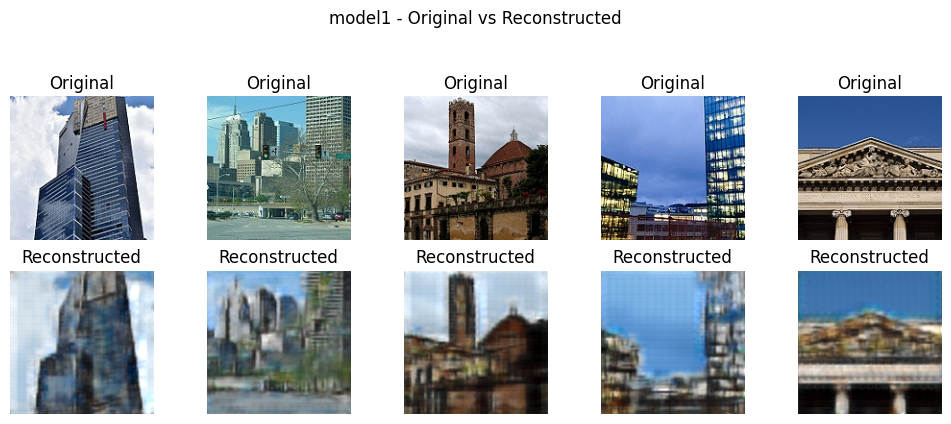


Classification Report:
              precision    recall  f1-score   support

   buildings       0.76      0.70      0.73       437
      forest       0.93      0.90      0.91       474
     glacier       0.77      0.74      0.76       553
    mountain       0.74      0.78      0.76       525
         sea       0.79      0.81      0.80       510
      street       0.76      0.83      0.79       501

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000


Training model2 with config: {'name': 'model2', 'BATCH_SIZE': 64, 'NUM_CLASSES': 6, 'EPOCHS': 10, 'LEARNING_RATE': 0.0005, 'IMAGE_SIZE': (150, 150), 'recon_weight': 0.3}


model2 - Epoch 1/10: 100%|██████████| 220/220 [00:32<00:00,  6.75it/s]


Epoch 1: Train Loss = 1.0714, Train Acc = 58.94%, Val Acc = 67.13%


model2 - Epoch 2/10: 100%|██████████| 220/220 [00:31<00:00,  6.88it/s]


Epoch 2: Train Loss = 0.7717, Train Acc = 71.12%, Val Acc = 72.30%


model2 - Epoch 3/10: 100%|██████████| 220/220 [00:31<00:00,  7.01it/s]


Epoch 3: Train Loss = 0.6272, Train Acc = 76.64%, Val Acc = 76.20%


model2 - Epoch 4/10: 100%|██████████| 220/220 [00:31<00:00,  6.88it/s]


Epoch 4: Train Loss = 0.4808, Train Acc = 82.69%, Val Acc = 75.80%


model2 - Epoch 5/10: 100%|██████████| 220/220 [00:31<00:00,  6.95it/s]


Epoch 5: Train Loss = 0.3432, Train Acc = 87.84%, Val Acc = 78.53%


model2 - Epoch 6/10: 100%|██████████| 220/220 [00:32<00:00,  6.82it/s]


Epoch 6: Train Loss = 0.2339, Train Acc = 92.04%, Val Acc = 77.47%


model2 - Epoch 7/10: 100%|██████████| 220/220 [00:32<00:00,  6.72it/s]


Epoch 7: Train Loss = 0.1600, Train Acc = 94.98%, Val Acc = 75.63%


model2 - Epoch 8/10: 100%|██████████| 220/220 [00:30<00:00,  7.16it/s]


Epoch 8: Train Loss = 0.1073, Train Acc = 96.84%, Val Acc = 74.50%


model2 - Epoch 9/10: 100%|██████████| 220/220 [00:31<00:00,  7.05it/s]


Epoch 9: Train Loss = 0.0628, Train Acc = 98.43%, Val Acc = 78.23%


model2 - Epoch 10/10: 100%|██████████| 220/220 [00:31<00:00,  7.04it/s]


Epoch 10: Train Loss = 0.0452, Train Acc = 98.96%, Val Acc = 76.93%


/tmp/ipykernel_31/3278735922.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_dir}/best_model.pth"))



Final Validation Accuracy for model2: 78.53%

Generating final reconstructions...


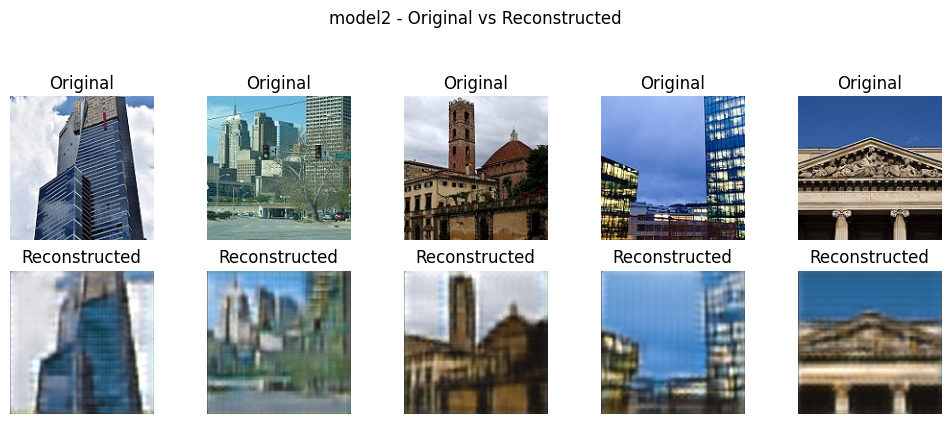


Classification Report:
              precision    recall  f1-score   support

   buildings       0.72      0.70      0.71       437
      forest       0.94      0.83      0.88       474
     glacier       0.79      0.75      0.77       553
    mountain       0.75      0.79      0.77       525
         sea       0.82      0.78      0.80       510
      street       0.73      0.85      0.78       501

    accuracy                           0.79      3000
   macro avg       0.79      0.78      0.79      3000
weighted avg       0.79      0.79      0.79      3000



In [8]:
# Train and evaluate both configurations
for config in configs:
    train_and_evaluate(config)